In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df = pd.read_csv("Non_Textual_and_Textual_Features.csv")

# Function to create labels based on the Boolean columns BUG and BIC of the dataset. Necessary for our dataset, might be optional for others.
def label_bool(is_bug,bic):
    if(is_bug==1 and bic==1):
        return 1 # Intrinsic
    elif(is_bug==1 and bic==0):
        return 0 # Extrinsic
    else:
        return -1 # Non-bug
    
df["Label"]=df.apply(lambda x: label_bool(x['BUG'],x['BIC']),axis=1)

df.head()

,Unnamed: 0.2,commit_id,author_date,bugcount,fixcount,la,ld,nf,nd,ns,...,BugId,Project,FixHashId,BUG,BIC,Comments,title,description,BFC_message,Label
0,0,0049967a874a3dca7c6ab8e8e84ca7dea21dc0b2,1395160653,0.0,1.0,29,12,2,2,1,...,1284162,neutron,0049967a874a3dca7c6ab8e8e84ca7dea21dc0b2,1,1,NaN,"Bug #1284162 in neutron: ""Cisco plugin fails t...",When the Cisco nexus plugin is configured on D...,Cisco plugin fails with ParseError no elem fou...,1
1,1,006a4e5e31a12d049c3d6308c3a2d73f57cd980f,1374767629,0.0,NaN,15,3,2,2,1,...,1307878,Glance,006a4e5e31a12d049c3d6308c3a2d73f57cd980f,0,0,“to avoid problems in the future”,"Bug #1307878 in Glance: ""Fix instances of muta...","In a few points throughout the codebase, mutab...",Allow insecure=True to be set in swiftclient\n...,-1
2,2,00ac56a100ac7329a01b5f1fa336b99e64778eaf,1401120475,NaN,1.0,16,4,4,3,1,...,1322180,nova,00ac56a100ac7329a01b5f1fa336b99e64778eaf,1,0,"""Legacy bdm in incoming parameters contains a ...","Bug #1322180 in OpenStack Compute (nova): ""Fai...",Launting an instance from bootable volume pass...,Run instance root device determination fix.\n\...,0
3,3,00f5125745dc72afbc9aeade8b780d7a3be49a30,1394439616,NaN,1.0,5,1,2,2,1,...,1288926,nova,00f5125745dc72afbc9aeade8b780d7a3be49a30,1,1,bug rebooting,"Bug #1288926 in OpenStack Compute (nova): ""inc...",This is using the latest nova from trunk. In o...,Don't allow reboot when instance in rebooting_...,1
4,4,011d99f300ea5d5f4ce48023bd04a795a4872287,1369792347,3.0,1.0,87,47,2,2,1,...,1175695,neutron,011d99f300ea5d5f4ce48023bd04a795a4872287,1,1,,"Bug #1175695 in neutron: ""L3 agent restart cau...","When L3 agent is restarted, it destroys all ex...",L3 Agent restart causes network outage\n\nWhen...,1


In [69]:
# removing  'tcmt','hcmt', 'self', 'ndev', 'age', 'nuc', 'app', 'aexp', 'rexp', 'oexp','arexp', 'rrexp', 'orexp', 'asexp', 'rsexp', 'osexp', 'asawr', 'rsawr','osawr'
df = df[df['Label']>-1]

# Converting boolean to 1 and 0
df['revd'] = df['revd'].apply(lambda x: 1 if x==True else 0)
df['self'] = df['self'].apply(lambda x: 1 if x==True else 0)

#Feature selection
x = df[['la', 'ld', 'nf', 'nd', 'ns', 'ent','bugcount', 'fixcount','revd', 'nrev', 'rtime']]
y = df['Label']

# Replacing NaN values with the mean of that column
#x = x.fillna(df.mean())
# Try with 0
x = x.fillna(0)
print(x)

x = np.array(x)
y= np.array(y)
print(x.shape)
print(y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)

print(x_train.shape, y_train.shape)

       la  ld  nf  nd  ns       ent  bugcount  fixcount  revd  nrev  \
0      29  12   2   2   1  0.999571       0.0       1.0     1   4.0   
2      16   4   4   3   1  0.960964       0.0       1.0     0   0.0   
3       5   1   2   2   1  1.000000       0.0       1.0     1   1.0   
4      87  47   2   2   1  0.963536       3.0       1.0     1  35.0   
5       3   2   2   2   1  0.721928       0.0       1.0     0   0.0   
...   ...  ..  ..  ..  ..       ...       ...       ...   ...   ...   
1872   23   6   2   2   1  0.978449       0.0       1.0     0   0.0   
1875    8   4   3   3   1  0.980834       0.0       1.0     1   6.0   
1876  113   6   6   3   1  0.908566       2.0       0.0     1  31.0   
1878   67  17   3   2   1  0.899800       0.0       1.0     0   0.0   
1879    2   2   1   1   1  0.000000       0.0       1.0     0   0.0   

           rtime  
0       146993.0  
2            0.0  
3      1043663.0  
4     24155803.0  
5            0.0  
...          ...  
1872         0

In [70]:
from autograd import grad
import autograd.numpy as np

def feature_normalizer(x):
    for i in range(x.shape[1]):
        col = [row[i] for row in x]
        x_max = np.max(col)
        x[:,i]=[a[i]/x_max for a in x]
    return x

def class_balancing(X, y):
    # Perform class balancing using SMOTE
    smote = SMOTE()
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced

def model(x,w):
    return w[0]+np.dot(x,w[1:])

def sigmoid(t):
    return 1/(1+np.exp(-t))

def cross_entropy(w,x,y):
    a = sigmoid(model(x,w))
    ind = np.argwhere(y==0)[:,0]
    cost = -np.sum(np.log(1-a[ind]))
    
    ind = np.argwhere(y==1)[:,0]
    cost -= np.sum(np.log(a[ind]))
    return cost/y.size

def gradient_descent(g,step,max_iter,w):
    gradient = grad(g)
    weight_history = [w]
    cost_history = [g(w)]
    
    for k in range(max_iter):
        grad_eval = gradient(w) #get the gradient
        grad_eval_norm = grad_eval/np.linalg.norm(grad_eval)  #Normalized gradient descent
        w = w - step*grad_eval_norm
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history, cost_history

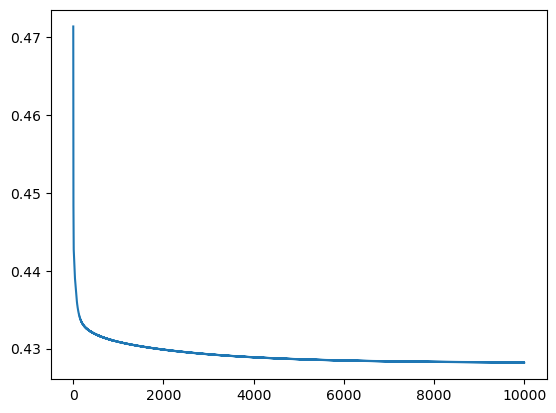

In [71]:
def c(w):
    c = cross_entropy(w,x_train,y_train)
    return c

iter = 10000
x_train = feature_normalizer(x_train)
w = np.array(np.random.rand(11+1,1))
a, b = gradient_descent(c,0.1,iter,w)
plt.figure(1)
plt.plot(b)

In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = np.sign(sigmoid(model(x_test, a[iter]))- 0.5)/2 +0.5

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[  8  62]
 [ 27 343]]
0.7977272727272727


In [75]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(x_train, y_train)

y_pred2 = classifier.predict(x_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))

[[ 30  40]
 [123 247]]
0.6295454545454545
